## Import modules

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR100
from torchvision.transforms import ToTensor

from config.config import get_config
from utils.earlystop import EarlyStop
from models.hrnet import HighResolutionNet

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# 시드 고정 함수
def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Model setting

In [3]:
DESCRIPTION = "hrnet w18 experiment()" # 예시: 실험 내용 기록용(한글 작성시 깨짐)

LOAD_WEIGHT = False # 기존 모델 가중치를 가져올지 여부
WEIGHT_PATH = "./save/20250220_152155/weight/model_epoch_200.pt" # 기존 모델 가중치 경로

## Device setting

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

def get_recommended_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

device = get_recommended_device()
print(device)

cuda


## Data setting

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

# 기본 transform (no augmentation)
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# 각각의 augmentation을 개별로 정의
random_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    base_transform
])

random_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    base_transform
])

color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    base_transform
])

random_rotation = transforms.Compose([
    transforms.RandomRotation(15),
    base_transform
])

# 원본 dataset
base_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=base_transform)

# 각 augmentation dataset
crop_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=random_crop)
flip_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=random_flip)
jitter_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=color_jitter)
rotation_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=random_rotation)

# 모두 합치기: 총 50,000 * 5 = 250,000개
combined_dataset = ConcatDataset([base_dataset, crop_dataset, flip_dataset, jitter_dataset, rotation_dataset])


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


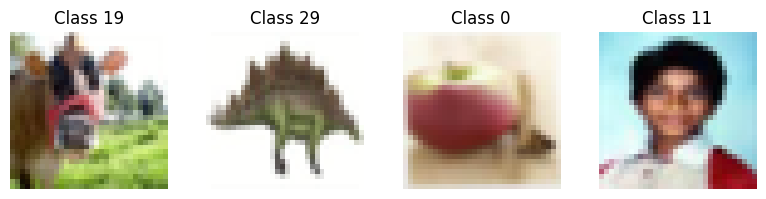

In [3]:
import matplotlib.pyplot as plt

# 몇 개만 시각화
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(8, 2))

# CIFAR-100 mean, std
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)

# 원래 이미지로 복원하는 transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
for i in range(num_images):
    img, label = flip_dataset[i]
    img = unnormalize(img)  # normalize 복원
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    img = img.clip(0, 1)  # 값 범위 맞추기

    axes[i].imshow(img)
    axes[i].set_title(f'Class {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train = CIFAR100(root='./data', train=True, download=True, transform=ToTensor())
test = CIFAR100(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [6]:
print(train)
print()
print(len(train[0]))
print()
print(train[0][1])

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

2

19


## Model setting

In [7]:
# 기본 config 불러오기
class Args:
    cfg = "config/hrnet_w18.yaml"
    opts = None
    batch_size = None
    data_path = None
    zip = None
    cache_mode = None
    resume = None
    accumulation_steps = None
    use_checkpoint = None
    output = None
    tag = None
    eval = None
    throughput = None
    local_rank = 0

args = Args()
cfg = get_config(args)

print(cfg)

=> merge config from config/hrnet_w18.yaml
AMP_OPT_LEVEL: O1
BASE: ['']
DATA:
  BATCH_SIZE: 128
  CACHE_MODE: part
  DATASET: cifar
  DATA_PATH: 
  IMG_SIZE: 32
  INTERPOLATION: bicubic
  NUM_WORKERS: 4
  PIN_MEMORY: True
  ZIP_MODE: False
EVAL_MODE: False
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.1
  DROP_RATE: 0.0
  HRNET:
    DROP_PATH_RATE: 0.2
    STAGE1:
      BLOCK: BOTTLENECK
      NUM_BLOCKS: [4]
      NUM_BRANCHES: 1
      NUM_CHANNELS: [64]
      NUM_MODULES: 1
    STAGE2:
      BLOCK: BASIC
      NUM_BLOCKS: [4, 4]
      NUM_BRANCHES: 2
      NUM_CHANNELS: [18, 36]
      NUM_MODULES: 1
    STAGE3:
      BLOCK: BASIC
      NUM_BLOCKS: [4, 4, 4]
      NUM_BRANCHES: 3
      NUM_CHANNELS: [18, 36, 72]
      NUM_MODULES: 4
    STAGE4:
      BLOCK: BASIC
      NUM_BLOCKS: [4, 4, 4, 4]
      NUM_BRANCHES: 4
      NUM_CHANNELS: [18, 36, 72, 144]
      NUM_MODULES: 3
  LABEL_SMOOTHING: 0.1
  NAME: hrnet_w18
  NUM_CLASSES: 1000
  RESUME: 
  RESUME_ONLY_MODEL: False
  TYPE: hrnet
OUTPU

In [ ]:
model = HighResolutionNet(cfg.MODEL.HRNET, num_classes=100)  # CIFAR10은 10 classes
model = model.to(device)

# 기존의 모델 로드할 경우
if LOAD_WEIGHT: 
    checkpoint = torch.load(WEIGHT_PATH)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg.TRAIN.BASE_LR, weight_decay=cfg.TRAIN.WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.TRAIN.EPOCHS)

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

save_folder = f"./save/{timestamp}" 
weight_folder = f"./save/{timestamp}/weight"

os.makedirs(weight_folder, exist_ok=True) #현재 시간으로 폴더 생성
log_file_path = os.path.join(save_folder, 'log.txt')

# log.txt에 모델 정보 기록
with open(log_file_path, 'a') as log_file:
    log_file.write('model: hrnet_w18\n')
    log_file.write(f'description: {DESCRIPTION}\n')
    log_file.write(str(cfg) + '\n\n')

In [ ]:
earlystop = EarlyStop()
best_valid_loss = float('inf')

# Metrics tracking
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(cfg.TRAIN.EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{cfg.TRAIN.EPOCHS}] - Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{cfg.TRAIN.EPOCHS} - Valid"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / total
    val_acc = 100. * correct / total
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    scheduler.step()

    # save epoch info
    result = f"Epoch [{epoch+1}/{cfg.TRAIN.EPOCHS}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.2f}% | Early Stop Count: {earlystop}"
    print(result)
    with open(log_file_path, 'a') as log_file:
        log_file.write(result + '\n')
        
    # Early Stopping
    if not earlystop.update_patience(best_valid_loss, val_loss):
        print("Early Stop.")
        break

    best_valid_loss = min(best_valid_loss, val_loss)

Epoch 1/300 - Valid: 100%|███████████████████████████████████████████████████████████| 313/313 [00:16<00:00, 19.20it/s]


Epoch [1/300] Train Loss: 4.0980, Train Acc: 7.59% Valid Loss: 3.8590, Valid Acc: 10.37%


Epoch 2/300 - Valid: 100%|███████████████████████████████████████████████████████████| 313/313 [00:16<00:00, 19.26it/s]

Epoch [2/300] Train Loss: 3.8116, Train Acc: 10.96% Valid Loss: 3.6081, Valid Acc: 14.79%


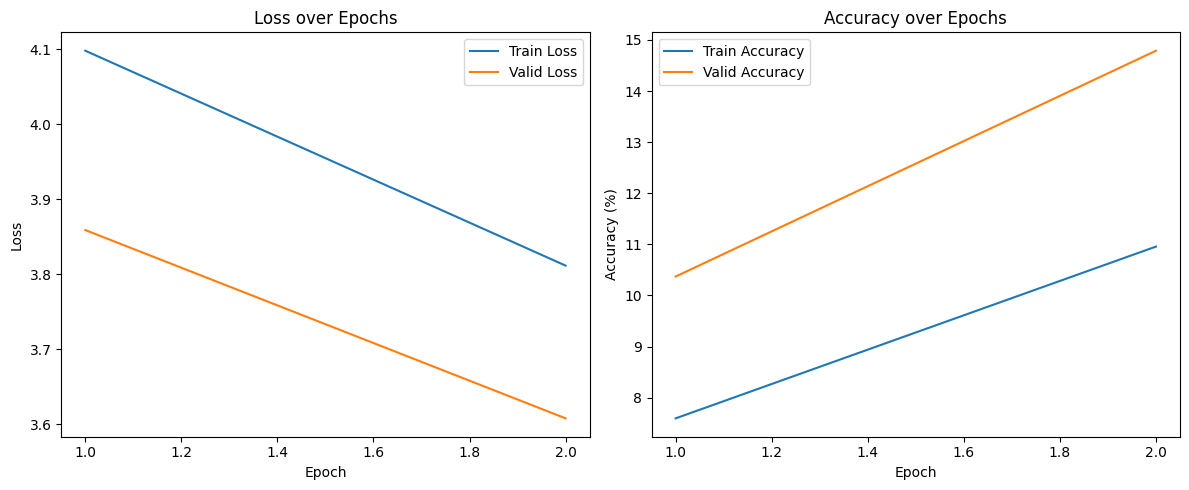

In [12]:
# Plotting
epochs = range(1, cfg.TRAIN.EPOCHS + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(f'{save_folder}/loss&accuracy.png')
plt.show()

In [ ]:
if(LOAD_WEIGHT==False):
    MODEL_PATH = os.path.join(weight_folder, "hrnet_test.pth")
    torch.save(model.state_dict(), MODEL_PATH)